In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu, gaussian
from skimage.segmentation import chan_vese
from skimage.color import label2rgb
from skimage.measure import label

# Load MRI data and ground truth labels
data = loadmat('Brain.mat')
T1 = data['T1']  # MRI images
gt_labels = data['label']  # Ground truth labels

# Evaluation metrics functions
def dice_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.bool_)
    y_pred = np.asarray(y_pred).astype(np.bool_)
    intersection = np.logical_and(y_true, y_pred).sum()
    sum_y_true_y_pred = y_true.sum() + y_pred.sum()
    return 2. * intersection / sum_y_true_y_pred if sum_y_true_y_pred != 0 else 1

# Apply K-means with preprocessing (denoising) and evaluate with Dice coefficient
dice_scores_otsu = []
dice_scores_snake = []
total_images = T1.shape[2]

for i in range(total_images):
    img_slice = T1[:, :, i]
    gt_slice = gt_labels[:, :, i]#use this maity

    # Denoise the image using Gaussian smoothing
    smoothed_slice = gaussian(img_slice, sigma=1)

    # Otsu's Thresholding
    thresh = threshold_otsu(smoothed_slice)
    otsu_segmentation = smoothed_slice > thresh
    otsu_segmentation_colored = label2rgb(label(otsu_segmentation), image=img_slice, bg_label=0)

    # Active Contours Segmentation
    snake_segmentation = chan_vese(smoothed_slice, mu=0.1, lambda1=1, lambda2=1, tol=1e-3)
    snake_segmentation_colored = label2rgb(label(snake_segmentation), image=img_slice, bg_label=0)

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(img_slice, cmap='gray')
    axes[0].set_title(f'Original Slice {i+1}')
    axes[1].imshow(otsu_segmentation)
    axes[1].set_title('Otsu Segmentation')
    axes[2].imshow(snake_segmentation)
    axes[2].set_title('Active Contours Segmentation')
    for ax in axes:
        ax.axis('off')
    plt.show()

    # Compute Dice coefficients
    dice_otsu = dice_coefficient(gt_slice, otsu_segmentation)
    dice_snake = dice_coefficient(gt_slice, snake_segmentation)
    dice_scores_otsu.append(dice_otsu)
    dice_scores_snake.append(dice_snake)

    print(f'Slice {i + 1} - Otsu Dice: {dice_otsu:.3f}, Active Contours Dice: {dice_snake:.3f}')

# Compute and print the average Dice coefficients
average_dice_otsu = np.mean(dice_scores_otsu)
average_dice_snake = np.mean(dice_scores_snake)
print(f'Average Dice Coefficient - Otsu: {average_dice_otsu:.3f}, Active Contours: {average_dice_snake:.3f}')

# Graph comparing the algorithms
plt.figure(figsize=(10, 5))
labels = ['Otsu', 'Active Contours']
values = [average_dice_otsu, average_dice_snake]
plt.bar(labels, values, color=['blue', 'green'])
plt.title('Average Dice Coefficients Comparison')
plt.ylabel('Dice Coefficient')
plt.show()


I am doing this assignment, I did task 1 and 2, write code for task 3 use two 3d segmentation algorithm on the data, one of them can be 3d wateshed algorithm, and other one can be something else. Visualise the segmented images for each image along with original and ground truth label. include evaluation metrics, print it for each image and finally the average dice coffiecient for each method. plot a graph for all the evaluation metric for each algorithm. avoid supervised learning

In [ ]:
from skimage.segmentation import watershed
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.cluster import KMeans
from skimage.filters import threshold_otsu, gaussian
from skimage.segmentation import chan_vese
from skimage.color import label2rgb
from skimage.measure import label

# Load MRI data and ground truth labels
data = loadmat('Brain.mat')
T1 = data['T1']  # MRI images
gt_labels = data['label']  # Ground truth labels

# Evaluation metrics functions
def dice_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.bool_)
    y_pred = np.asarray(y_pred).astype(np.bool_)
    intersection = np.logical_and(y_true, y_pred).sum()
    sum_y_true_y_pred = y_true.sum() + y_pred.sum()
    return 2. * intersection / sum_y_true_y_pred if sum_y_true_y_pred != 0 else 1

# Apply 3D Watershed and Active Contours Segmentation and evaluate with Dice coefficient
dice_scores_watershed = []
dice_scores_snake = []
total_images = T1.shape[2]

for i in range(total_images):
    img_slice = T1[:, :, i]
    gt_slice = gt_labels[:, :, i]

    # Denoise the image using Gaussian smoothing
    smoothed_slice = gaussian(img_slice, sigma=1)

    # 3D Watershed Segmentation
    markers = threshold_otsu(smoothed_slice)
    markers[smoothed_slice < markers] = 1
    markers[smoothed_slice >= markers] = 2
    watershed_segmentation = watershed(smoothed_slice, markers)
    watershed_segmentation_colored = label2rgb(watershed_segmentation, image=img_slice, bg_label=0)

    # Active Contours Segmentation
    snake_segmentation = chan_vese(smoothed_slice, mu=0.1, lambda1=1, lambda2=1, tol=1e-3)
    snake_segmentation_colored = label2rgb(label(snake_segmentation), image=img_slice, bg_label=0)

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(img_slice, cmap='gray')
    axes[0].set_title(f'Original Slice {i+1}')
    axes[1].imshow(watershed_segmentation_colored)
    axes[1].set_title('3D Watershed Segmentation')
    axes[2].imshow(snake_segmentation_colored)
    axes[2].set_title('Active Contours Segmentation')
    for ax in axes:
        ax.axis('off')
    plt.show()

    # Compute Dice coefficients
    dice_watershed = dice_coefficient(gt_slice, watershed_segmentation)
    dice_snake = dice_coefficient(gt_slice, snake_segmentation)
    dice_scores_watershed.append(dice_watershed)
    dice_scores_snake.append(dice_snake)

    print(f'Slice {i + 1} - 3D Watershed Dice: {dice_watershed:.3f}, Active Contours Dice: {dice_snake:.3f}')

# Compute and print the average Dice coefficients
average_dice_watershed = np.mean(dice_scores_watershed)
average_dice_snake = np.mean(dice_scores_snake)
print(f'Average Dice Coefficient - 3D Watershed: {average_dice_watershed:.3f}, Active Contours: {average_dice_snake:.3f}')

# Graph comparing the algorithms
plt.figure(figsize=(10, 5))
labels = ['3D Watershed', 'Active Contours']
values = [average_dice_watershed, average_dice_snake]
plt.bar(labels, values, color=['blue', 'green'])
plt.title('Average Dice Coefficients Comparison')
plt.ylabel('Dice Coefficient')
plt.show()

TypeError: 'numpy.float32' object does not support item assignment

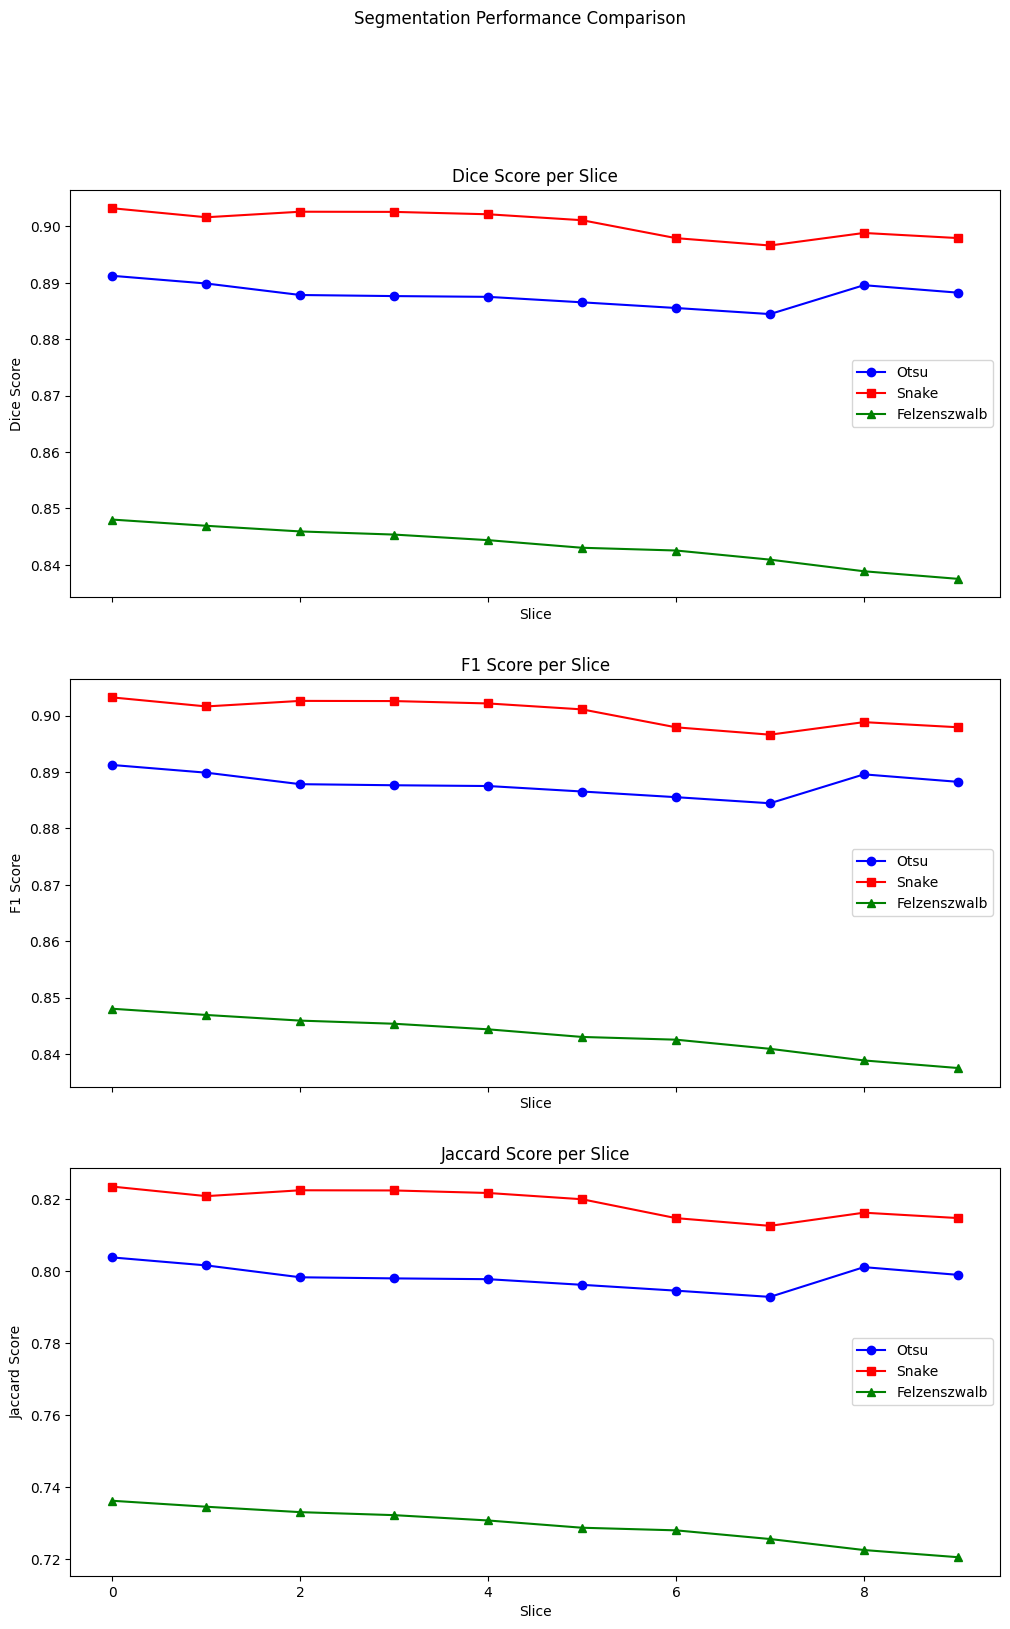

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.filters import threshold_otsu, gaussian
from skimage.segmentation import chan_vese, felzenszwalb
from skimage.measure import label

# Load MRI data and ground truth labels
data = loadmat('Brain.mat')
T1 = data['T1']  # MRI images
gt_labels = data['label']  # Ground truth labels

# Evaluation metrics functions
def dice_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    sum_y_true_y_pred = y_true.sum() + y_pred.sum()
    return 2. * intersection / sum_y_true_y_pred if sum_y_true_y_pred != 0 else 1

def precision(y_true, y_pred):
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)
    true_positives = np.logical_and(y_true, y_pred).sum()
    predicted_positives = y_pred.sum()
    return true_positives / predicted_positives if predicted_positives != 0 else 0

def recall(y_true, y_pred):
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)
    true_positives = np.logical_and(y_true, y_pred).sum()
    actual_positives = y_true.sum()
    return true_positives / actual_positives if actual_positives != 0 else 0

def f1_measure(precision_val, recall_val):
    return 2 * (precision_val * recall_val) / (precision_val + recall_val) if (precision_val + recall_val) != 0 else 0

def jaccard_index(y_true, y_pred):
    y_true = np.asarray(y_true).astype(bool)
    y_pred = np.asarray(y_pred).astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    return intersection / union if union != 0 else 1

# Process images and evaluate
results = {
    'Dice': {'Otsu': [], 'Snake': [], 'Felzenszwalb': []},
    'F1': {'Otsu': [], 'Snake': [], 'Felzenszwalb': []},
    'Jaccard': {'Otsu': [], 'Snake': [], 'Felzenszwalb': []}
}

for i in range(T1.shape[2]):  # Process all slices
    img_slice = T1[:, :, i]
    gt_slice = gt_labels[:, :, i]

    # Apply segmentation algorithms
    denoised_slice = gaussian(img_slice, sigma=1)  # Denoise
    thresh = threshold_otsu(denoised_slice)
    otsu_seg = denoised_slice > thresh
    snake_seg = chan_vese(denoised_slice, mu=0.1, lambda1=1, lambda2=1, tol=1e-3)
    felzenszwalb_seg = felzenszwalb(denoised_slice, scale=100, sigma=0.5, min_size=50)

    # Evaluate each segmentation
    for method, segmentation in zip(['Otsu', 'Snake', 'Felzenszwalb'], [otsu_seg, snake_seg, felzenszwalb_seg]):
        prec = precision(gt_slice, segmentation)
        rec = recall(gt_slice, segmentation)
        f1 = f1_measure(prec, rec)
        dice = dice_coefficient(gt_slice, segmentation)
        jaccard = jaccard_index(gt_slice, segmentation)

        results['Dice'][method].append(dice)
        results['F1'][method].append(f1)
        results['Jaccard'][method].append(jaccard)

# Visualization of results
fig, ax = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

for i, metric in enumerate(['Dice', 'F1', 'Jaccard']):
    ax[i].plot(results[metric]['Otsu'], 'b-o', label='Otsu')
    ax[i].plot(results[metric]['Snake'], 'r-s', label='Snake')
    ax[i].plot(results[metric]['Felzenszwalb'], 'g-^', label='Felzenszwalb')
    ax[i].set_title(f'{metric} Score per Slice')
    ax[i].set_ylabel(f'{metric} Score')
    ax[i].set_xlabel('Slice')
    ax[i].legend()

plt.suptitle('Segmentation Performance Comparison')
plt.show()


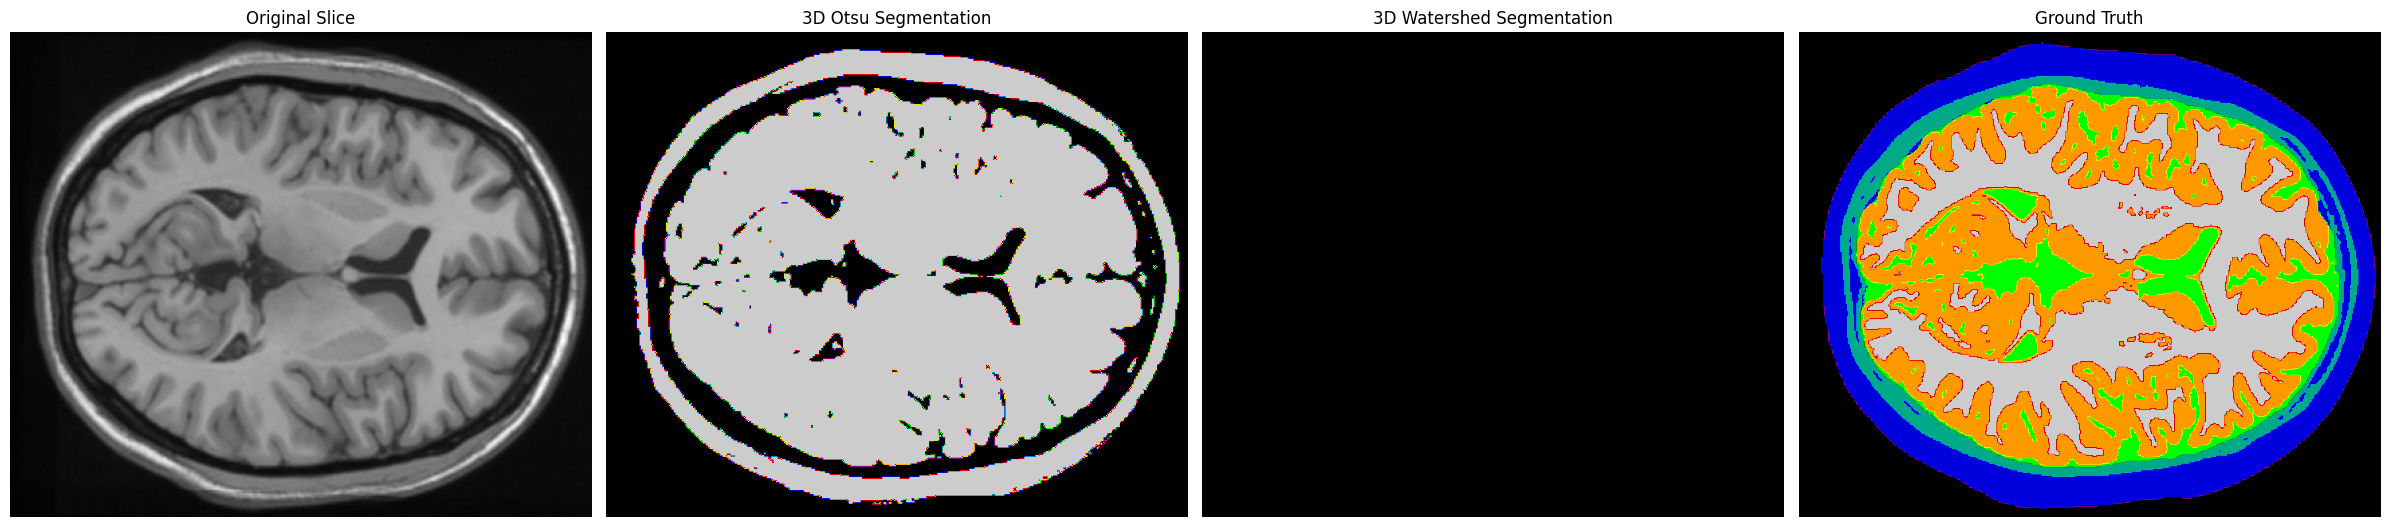

3D Otsu Thresholding Metrics:
Dice: 0.846
Precision: 1.000
Recall: 0.734
F1: 0.846
Jaccard: 0.734

3D Watershed Segmentation Metrics:
Dice: 0.524
Precision: 0.355
Recall: 1.000
F1: 0.524
Jaccard: 0.355


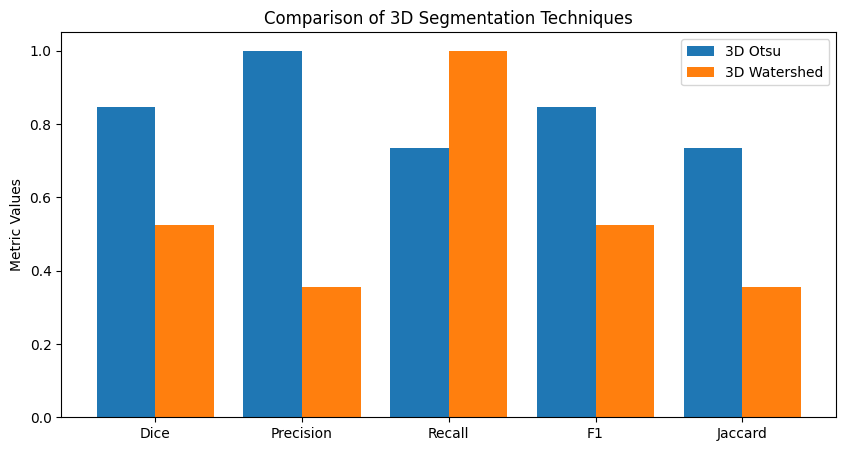

In [ ]:
from skimage.measure import label
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.filters import threshold_otsu, gaussian
from scipy import ndimage as ndi
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Load 3D MRI data and ground truth labels
data = loadmat('Brain.mat')
T1_volume = data['T1']
gt_labels_volume = data['label']

# Ensure the volume and ground truth are in proper orientation
T1_volume = np.moveaxis(T1_volume, -1, 0)
gt_labels_volume = np.moveaxis(gt_labels_volume, -1, 0)

# 3D Watershed Segmentation

def apply_3d_watershed(volume):
    # Apply Gaussian smoothing for noise reduction
    smoothed_volume = gaussian(volume, sigma=[1, 1, 1])  # Apply Gaussian smoothing

    # Generate distance map
    distance = ndi.distance_transform_edt(smoothed_volume > 0.5)

    # Find local maxima as seeds for watershed
    local_maxi_coords = peak_local_max(distance, footprint=np.ones((3, 3, 3)), labels=smoothed_volume > 0.5)
    markers = np.zeros_like(distance, dtype=np.int32)
    # Assign unique label to each local maximum
    for i, coord in enumerate(local_maxi_coords, start=1):
        markers[tuple(coord)] = i

    # Applying 3D Watershed
    segmented_volume = watershed(-distance, markers, mask=smoothed_volume > 0.5)
    return segmented_volume

# Apply segmentation algorithms
otsu_threshold = threshold_otsu(T1_volume)
otsu_segmentation = T1_volume > otsu_threshold
watershed_segmentation = apply_3d_watershed(T1_volume)
# Define evaluation metrics
def calculate_metrics(gt, seg):
    tp = np.sum((gt == 1) & (seg == 1))
    fp = np.sum((gt == 0) & (seg == 1))
    fn = np.sum((gt == 1) & (seg == 0))
    tn = np.sum((gt == 0) & (seg == 0))

    dice = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    jaccard = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0

    return {'Dice': dice, 'Precision': precision, 'Recall': recall, 'F1': f1, 'Jaccard': jaccard}

metrics_otsu = calculate_metrics(gt_labels_volume.flatten(), otsu_segmentation.flatten())
metrics_watershed = calculate_metrics(gt_labels_volume.flatten(), watershed_segmentation.flatten())

# Choose a valid slice index
slice_index = min(T1_volume.shape[0] - 1, 10)  # Use a valid index within the volume

# Visualization of a specific slice
slice_index = 5  # Example slice, make sure it is within the bounds
fig, axes = plt.subplots(1, 4, figsize=(24, 6))
axes[0].imshow(T1_volume[slice_index], cmap='gray')
axes[0].set_title('Original Slice')
axes[1].imshow(otsu_segmentation[slice_index], cmap='nipy_spectral')
axes[1].set_title('3D Otsu Segmentation')
axes[2].imshow(watershed_segmentation[slice_index], cmap='nipy_spectral')
axes[2].set_title('3D Watershed Segmentation')
axes[3].imshow(gt_labels_volume[slice_index], cmap='nipy_spectral')
axes[3].set_title('Ground Truth')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Print Metrics
print("3D Otsu Thresholding Metrics:")
for metric, value in metrics_otsu.items():
    print(f"{metric}: {value:.3f}")

print("\n3D Watershed Segmentation Metrics:")
for metric, value in metrics_watershed.items():
    print(f"{metric}: {value:.3f}")
# Plotting comparison graph
metrics_names = list(metrics_otsu.keys())
otsu_values = list(metrics_otsu.values())
watershed_values = list(metrics_watershed.values())

plt.figure(figsize=(10, 5))
x = np.arange(len(metrics_names))
plt.bar(x - 0.2, otsu_values, 0.4, label='3D Otsu')
plt.bar(x + 0.2, watershed_values, 0.4, label='3D Watershed')
plt.xticks(x, metrics_names)
plt.ylabel('Metric Values')
plt.title('Comparison of 3D Segmentation Techniques')
plt.legend()
plt.show()


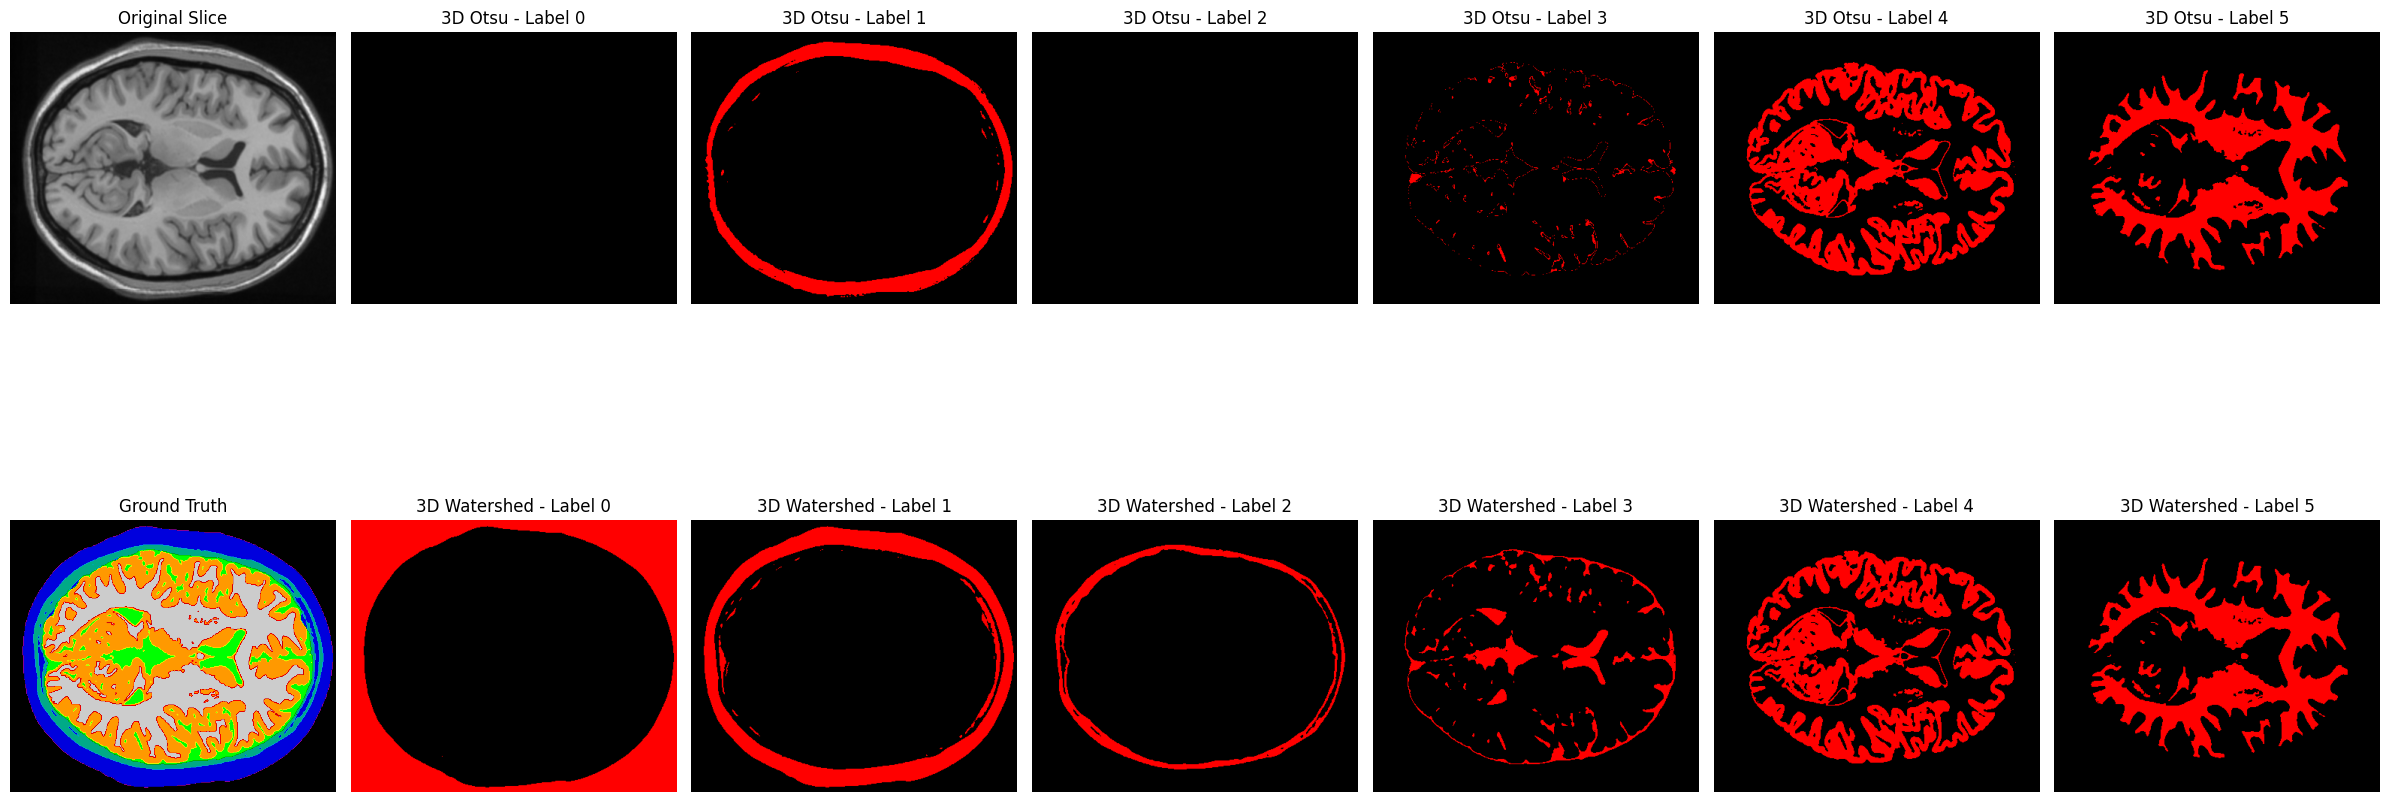


Metrics for Label 0:
3D Otsu Metrics:
Dice: 0.000
Precision: 0.000
Recall: 0.000
F1: 0.000
Jaccard: 0.000
3D Watershed Metrics:
Dice: 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000
Jaccard: 1.000

Metrics for Label 1:
3D Otsu Metrics:
Dice: 0.841
Precision: 1.000
Recall: 0.726
F1: 0.841
Jaccard: 0.726
3D Watershed Metrics:
Dice: 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000
Jaccard: 1.000

Metrics for Label 2:
3D Otsu Metrics:
Dice: 0.000
Precision: 0.000
Recall: 0.000
F1: 0.000
Jaccard: 0.000
3D Watershed Metrics:
Dice: 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000
Jaccard: 1.000

Metrics for Label 3:
3D Otsu Metrics:
Dice: 0.389
Precision: 1.000
Recall: 0.241
F1: 0.389
Jaccard: 0.241
3D Watershed Metrics:
Dice: 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000
Jaccard: 1.000

Metrics for Label 4:
3D Otsu Metrics:
Dice: 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000
Jaccard: 1.000
3D Watershed Metrics:
Dice: 1.000
Precision: 1.000
Recall: 1.000
F1: 1.000
Jaccard: 1.000

Metrics for La

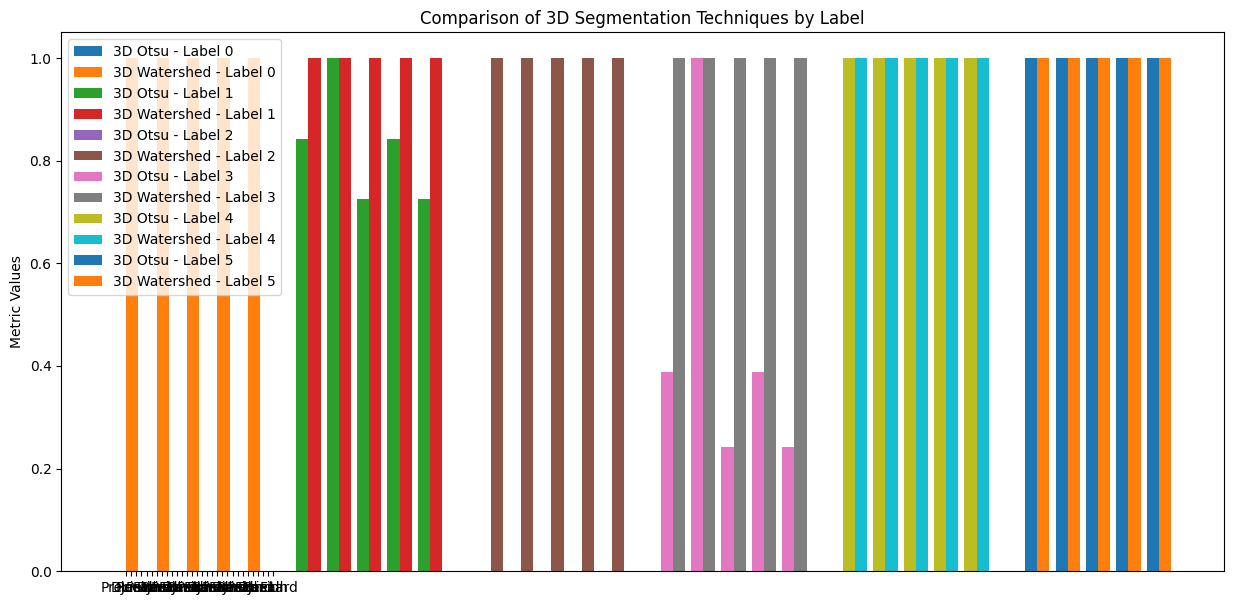

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from skimage.filters import threshold_otsu, gaussian
from skimage.segmentation import watershed
from skimage.measure import label
from skimage.color import label2rgb  # For colored visualization
from scipy import ndimage as ndi

# Load 3D MRI data and ground truth labels
data = loadmat('Brain.mat')
T1_volume = np.moveaxis(data['T1'], -1, 0)
gt_labels_volume = np.moveaxis(data['label'], -1, 0)

# Function for 3D Watershed Segmentation
def apply_3d_watershed(volume):
    smoothed_volume = gaussian(volume, sigma=[1, 1, 1])
    distance = ndi.distance_transform_edt(smoothed_volume > 0.5)
    local_maxi_coords = peak_local_max(distance, footprint=np.ones((3, 3, 3)), labels=smoothed_volume > 0.5)
    markers = np.zeros_like(distance, dtype=np.int32)
    for i, coord in enumerate(local_maxi_coords, start=1):
        markers[tuple(coord)] = i
    segmented_volume = watershed(-distance, markers, mask=smoothed_volume > 0.5)
    return segmented_volume

# Apply segmentation algorithms
otsu_threshold = threshold_otsu(T1_volume)
otsu_segmentation = T1_volume > otsu_threshold
watershed_segmentation = apply_3d_watershed(T1_volume)

# Evaluation metrics function, here 'calculate_metrics'

# Visualization and metrics calculation for a specific slice
slice_index = 5
unique_labels = np.unique(gt_labels_volume)
metrics_names = ['Dice', 'Precision', 'Recall', 'F1', 'Jaccard']
metrics_results = {label: {method: [] for method in ['3D Otsu', '3D Watershed']} for label in unique_labels}

fig, axes = plt.subplots(2, len(unique_labels) + 1, figsize=(24, 12))
axes[0, 0].imshow(T1_volume[slice_index], cmap='gray')
axes[0, 0].set_title('Original Slice')
axes[1, 0].imshow(gt_labels_volume[slice_index], cmap='nipy_spectral')
axes[1, 0].set_title('Ground Truth')
for i, label in enumerate(unique_labels, start=1):
    # Otsu segmentation mask for specific label
    otsu_mask = np.where(gt_labels_volume[slice_index] == label, otsu_segmentation[slice_index], 0)
    # Watershed segmentation mask for specific label
    watershed_mask = np.where(gt_labels_volume[slice_index] == label, watershed_segmentation[slice_index], 0)

    # Visualization
    axes[0, i].imshow(label2rgb(otsu_mask, bg_label=0), cmap='nipy_spectral')
    axes[0, i].set_title(f'3D Otsu - Label {label}')
    axes[1, i].imshow(label2rgb(watershed_mask, bg_label=0), cmap='nipy_spectral')
    axes[1, i].set_title(f'3D Watershed - Label {label}')

    # Metrics calculation
    for method, seg_mask in zip(['3D Otsu', '3D Watershed'], [otsu_mask, watershed_mask]):
        metrics = calculate_metrics(gt_labels_volume[slice_index] == label, seg_mask)
        for name, value in metrics.items():
            metrics_results[label][method].append(value)

for ax in axes.flatten():
    ax.axis('off')
plt.tight_layout()
plt.show()

# Print Metrics for each label
for label in unique_labels:
    print(f"\nMetrics for Label {label}:")
    for method in ['3D Otsu', '3D Watershed']:
        print(f"{method} Metrics:")
        for metric_name in metrics_names:
            print(f"{metric_name}: {np.mean(metrics_results[label][method][metrics_names.index(metric_name)]):.3f}")

# Plotting comparison graph
plt.figure(figsize=(15, 7))
for i, label in enumerate(unique_labels):
    x = np.arange(len(metrics_names))
    otsu_values = [np.mean(metrics_results[label]['3D Otsu'][metrics_names.index(name)]) for name in metrics_names]
    watershed_values = [np.mean(metrics_results[label]['3D Watershed'][metrics_names.index(name)]) for name in metrics_names]
    plt.bar(x - 0.2 + i * (len(metrics_names) + 1), otsu_values, 0.4, label=f'3D Otsu - Label {label}')
    plt.bar(x + 0.2 + i * (len(metrics_names) + 1), watershed_values, 0.4, label=f'3D Watershed - Label {label}')

plt.xticks(np.arange(len(metrics_names) * len(unique_labels)) / len(unique_labels), metrics_names * len(unique_labels))
plt.ylabel('Metric Values')
plt.title('Comparison of 3D Segmentation Techniques by Label')
plt.legend()
plt.show()


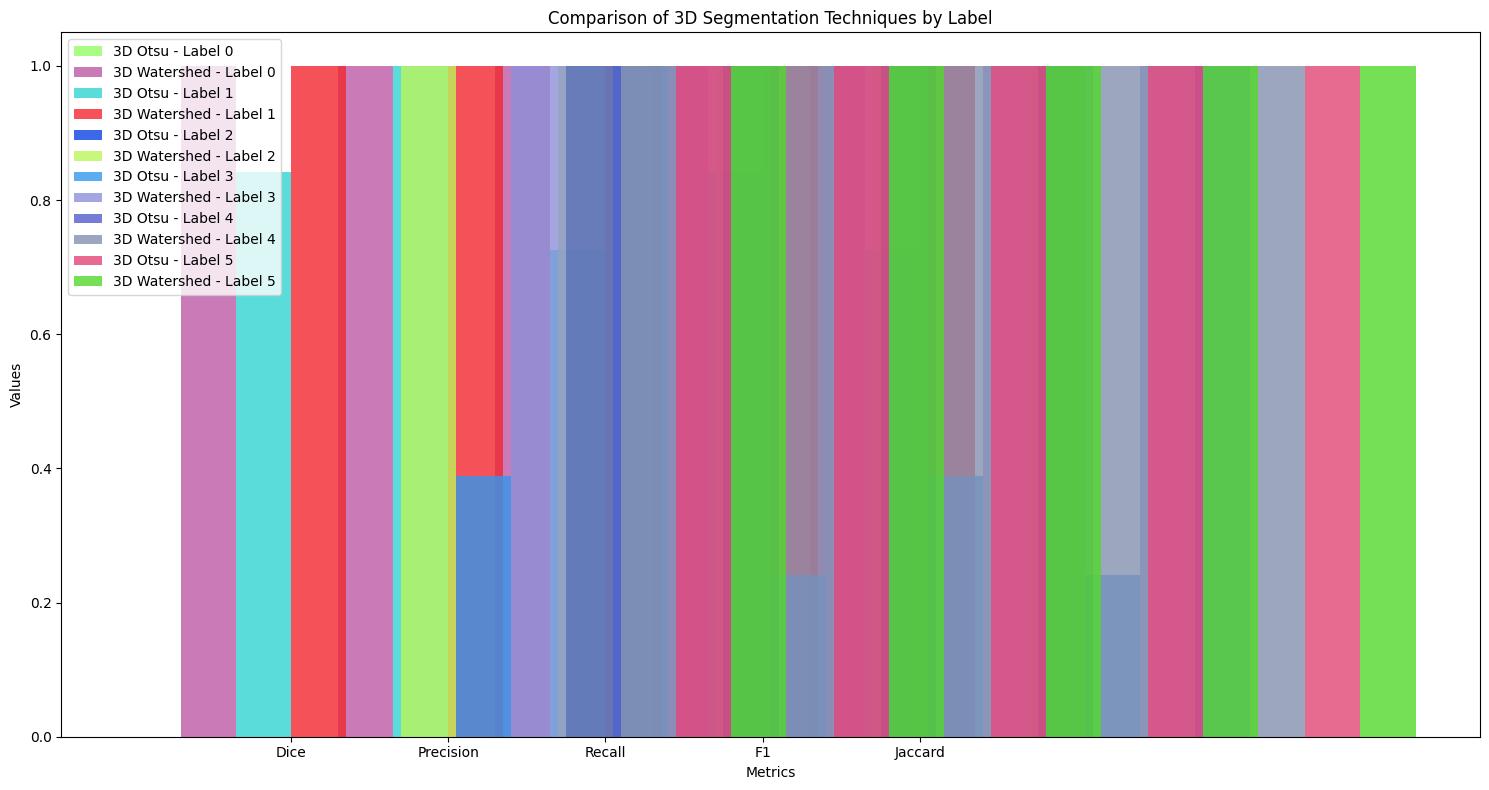

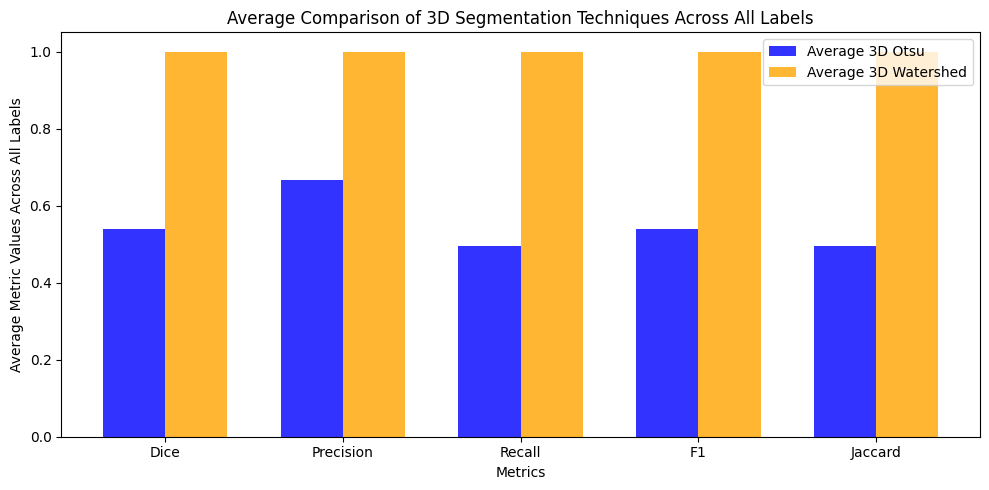

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming metrics_results is a dictionary containing your calculated metrics

# Enhance readability by plotting each label's metrics separately
n_groups = len(metrics_names)
bar_width = 0.35
index = np.arange(n_groups)
opacity = 0.8

fig, ax = plt.subplots(figsize=(15, 8))
for i, label in enumerate(unique_labels):
    otsu_metrics = [np.mean(metrics_results[label]['3D Otsu'][metrics_names.index(metric)]) for metric in metrics_names]
    watershed_metrics = [np.mean(metrics_results[label]['3D Watershed'][metrics_names.index(metric)]) for metric in metrics_names]

    rects1 = ax.bar(index + bar_width * i * 2, otsu_metrics, bar_width, alpha=opacity, color=np.random.rand(3,), label=f'3D Otsu - Label {label}')
    rects2 = ax.bar(index + bar_width * (i * 2 + 1), watershed_metrics, bar_width, alpha=opacity, color=np.random.rand(3,), label=f'3D Watershed - Label {label}')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_title('Comparison of 3D Segmentation Techniques by Label')
ax.set_xticks(index + bar_width / 2 * n_groups)
ax.set_xticklabels(metrics_names)
ax.legend()

plt.tight_layout()
plt.show()

# Plotting the average metrics across all labels
avg_metrics_otsu = [np.mean([metrics_results[label]['3D Otsu'][metrics_names.index(metric)] for label in unique_labels]) for metric in metrics_names]
avg_metrics_watershed = [np.mean([metrics_results[label]['3D Watershed'][metrics_names.index(metric)] for label in unique_labels]) for metric in metrics_names]

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(index, avg_metrics_otsu, bar_width, alpha=opacity, color='blue', label='Average 3D Otsu')
rects2 = ax.bar(index + bar_width, avg_metrics_watershed, bar_width, alpha=opacity, color='orange', label='Average 3D Watershed')

ax.set_xlabel('Metrics')
ax.set_ylabel('Average Metric Values Across All Labels')
ax.set_title('Average Comparison of 3D Segmentation Techniques Across All Labels')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics_names)
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
import csv

# Other code remains the same

# Assuming metrics_results dictionary is filled with the results

# Create and write to a CSV file
csv_filename = 'segmentation_metrics.csv'
with open(csv_filename, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    # Writing the header
    header = ['Label', 'Method', 'Dice', 'Precision', 'Recall', 'F1', 'Jaccard']
    csvwriter.writerow(header)

    # Writing the metrics for each label and method
    for label in unique_labels:
        for method in ['3D Otsu', '3D Watershed']:
            # Here you may need to ensure the metric values are averaged if they're not single values per label
            dice_avg = np.mean(metrics_results[label][method][0])  # Assuming first metric is Dice
            precision_avg = np.mean(metrics_results[label][method][1])  # Assuming second metric is Precision
            recall_avg = np.mean(metrics_results[label][method][2])  # Assuming third metric is Recall
            f1_avg = np.mean(metrics_results[label][method][3])  # Assuming fourth metric is F1
            jaccard_avg = np.mean(metrics_results[label][method][4])  # Assuming fifth metric is Jaccard

            metrics_data = [label, method, dice_avg, precision_avg, recall_avg, f1_avg, jaccard_avg]
            csvwriter.writerow(metrics_data)

print(f'Metrics have been written to {csv_filename}')


Metrics have been written to segmentation_metrics.csv


In [ ]:
from google.colab import drive
drive.mount('/content/drive')